<a href="https://colab.research.google.com/github/avannig11/Computational-Clustering-of-Media-Biases/blob/main/Farmers_protests_Framing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Media Cloud Data Analysis: Farmers Protest

In [9]:
%matplotlib notebook
%matplotlib inline 
import pandas as pd
import numpy as np

import os
import datetime as dt
import math
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.widgets import Slider, Button
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.patches as patch

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize #<- For finding tokens (small divisions) from a large sample of text
from nltk.corpus import stopwords #<- For calling the know stopwords in english (e.g, articles, connectors)
from nltk.corpus import wordnet #<- For calling a lexical database in eglish with meanings, synonyms, antonyms, and more 
from nltk.stem import WordNetLemmatizer #<- For normalizing the words in a text, for example, different conjugations of a verb and its brings its simple form.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer #using BERT transformer 
import torch


import umap

import gensim #<- Topic modelling library 
import gensim.corpora as corpora #<- To create a corpus of our text


#Libraries for visualizing the topics in a topic model from a corpus (gensim):
import pyLDAvis #<- Visualization library
import pyLDAvis.gensim_models #<- Connecting with gensim


from googletrans import Translator, constants
#from googletrans import Translator, constants


import networkx as nx
# import communityhdbscan
from collections import Counter



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data extraction

In [14]:
all_articles = pd.read_csv("All Stories.csv")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Total number of stories in the course of 3 months**

In [15]:
all_articles.count()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


stories_id              30307
title                   30307
url                     30307
publish_date            30088
media_name              30307
media_id                30307
media_inlink_count      30307
inlink_count            30307
outlink_count           30307
facebook_share_count    30306
post_count                  0
author_count                0
channel_count               0
dtype: int64

In [16]:

#Filtering 1 : Removing 'undateable' entries (twitter as a source) 
all_articles = all_articles[all_articles['publish_date'] != 'undateable'] #twitter data is undateable? Could analyse?

# Making a new column exclusively for dates for later filtering
all_articles['date'] = pd.to_datetime(all_articles['publish_date'].str[:10]) #cropping the time from published date

#Filtering 2 : Removing outliers: Restricting the dates to the original Media Cloud query
all_articles['publish_date'] = pd.to_datetime(all_articles['publish_date'])
all_articles = all_articles[(all_articles['publish_date'] > '2020-08-31') &
                            (all_articles['publish_date']  < '2021-04-30')]

all_articles = all_articles.sort_values(by= ['publish_date'], ascending = False)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-9fbb7897aa16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_articles['date'] = pd.to_datetime(all_articles['publish_date'].str[:10]) #cropping the time from published date
<ipython-input-16-9fbb7897aa16>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [17]:
#adding additional column telling the day of record keeping
dayList = []
uniqueDates = sorted(all_articles.date.unique())

for a, b in all_articles.date.iteritems():
    for i in range(len(uniqueDates)):
        if b == uniqueDates[i]:
            dayList.append(int(i+1))

all_articles['Day'] = dayList

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-8b30da050c12>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for a, b in all_articles.date.iteritems():


In [18]:
#Final number of entries 
print('The total number of articles after filtering:'+ str(all_articles.stories_id.count()))

The total number of articles after filtering:29931


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Media houses which wrote the most articles** 

In [19]:
#Grouping media geoups with the number of articles published
total_per_media = all_articles.groupby('media_name').count()
total_per_media = total_per_media.loc[:,['title']]
total_per_media = total_per_media.sort_values(by= ['title'], ascending = False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#total number of media articles
len(total_per_media['title'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


195

In [21]:
# Function to find out what percent of the total articles are covered by what number of newspapers

def percent2ind(perc, totalArticles):
    nArticles = math.floor(perc/100 * totalArticles )
    sum = 0
    ind = 0
    while sum < nArticles:
        sum += total_per_media['title'][ind]
        ind += 1
        #print(ind)
        #print(sum)
    return ind-1 , sum

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


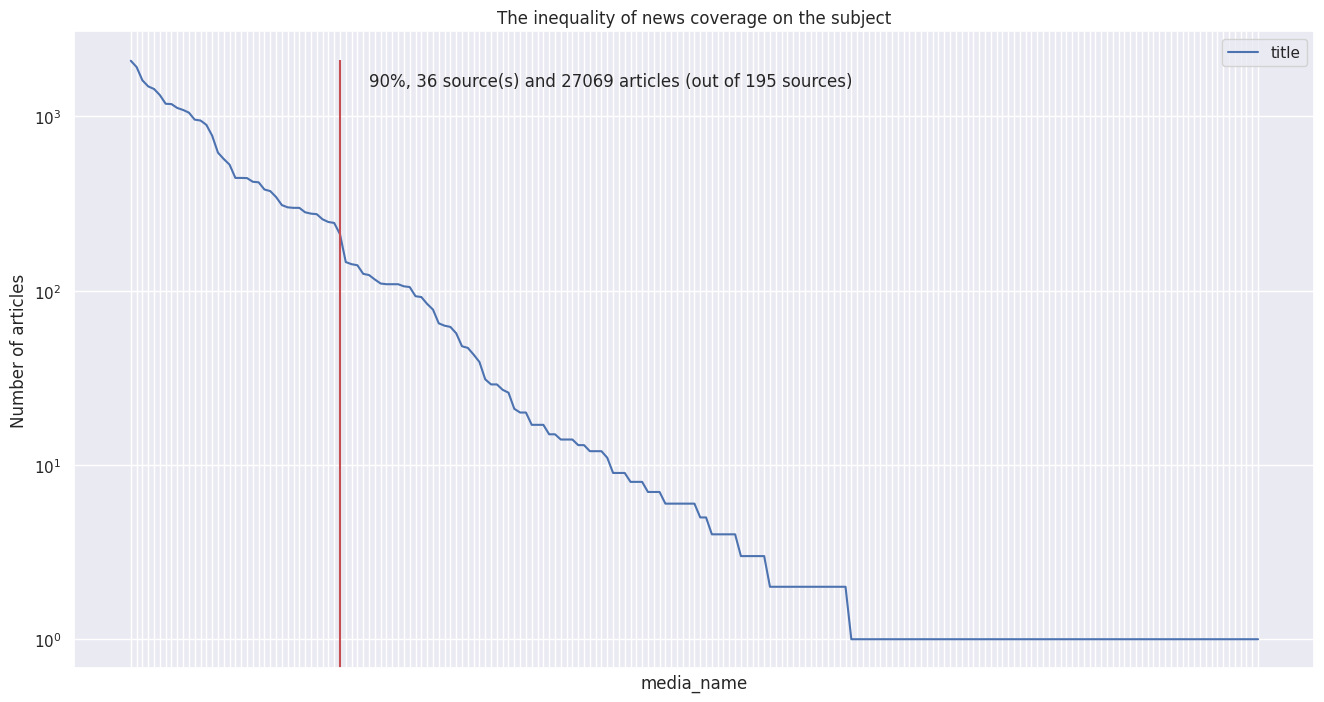

In [22]:
#plotting the coverage of the issue by media house

# Defining the variables for 
totalArticles = 29931
perc = 90

#finding the number of  percentage of
ind, sumArticles =  percent2ind(perc, totalArticles)

ann = str(perc)+'%'+', '+str(ind)+' source(s) and '+str(sumArticles)+' articles ('+'out of '+str(len(total_per_media['title']))+' sources)' 

sns.set('talk')
sns.set_style('ticks')

sns.set(rc={'figure.figsize':(16,8.27)})

mp = sns.lineplot(data = total_per_media)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.vlines(ind, 0, 2100, color = 'r') 

plt.annotate(ann,
            xy=(ind+5, 1500),  
            #xytext=(perDate.index[146], 647),  
            #arrowprops=dict(facecolor='black', shrink=0.05)
            )

plt.yscale('log')
plt.ylabel('Number of articles')
plt.title('The inequality of news coverage on the subject')

#collecteing the top sources
topSources = total_per_media.head(ind).index.tolist()

#Adding media sources codes for later
all_articles['mediaCode'] = [int(total_per_media.index.to_list().index(all_articles.iloc[i,4])) + 1 
                             for i in range(len(all_articles.index))]


In [23]:
all_df = all_articles[ all_articles.media_name.isin(topSources)]

print('The total number of articles after removing media sources with few articles:'+ str(all_df.stories_id.count()))

The total number of articles after removing media sources with few articles:26858


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Plotting the most popular days of the news coverage**

In [24]:
all_articles.head(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stories_id,title,url,publish_date,media_name,media_id,media_inlink_count,inlink_count,outlink_count,facebook_share_count,post_count,author_count,channel_count,date,Day,mediaCode
25754,1917010035,India's deepening water crisis at the heart of...,https://www.newindianexpress.com/nation/2021/a...,2021-04-29 22:55:06.040946,newindianexpress.com,100063,0,0,0,0.0,NaN,NaN,NaN,2021-04-29,238,5
25752,1916811237,Our corona warriors are risking life and limb ...,https://www.freepressjournal.in/analysis/our-c...,2021-04-29 17:00:00.000000,freepressjournal.in,136476,0,0,0,1.0,NaN,NaN,NaN,2021-04-29,238,16
25745,1916556624,Farmer unions ready to discuss agri laws with ...,https://timesofindia.indiatimes.com/india/farm...,2021-04-29 16:43:41.000000,The Times of India,39784,0,0,0,26.0,NaN,NaN,NaN,2021-04-29,238,1
25747,1916738759,Ready For Talks But It Should Be About Repeali...,http://feedproxy.google.com/~r/NDTV-LatestNews...,2021-04-29 15:08:00.000000,"NDTV.com: India, Business, Bollywood, Cricket,...",17973,0,0,0,0.0,NaN,NaN,NaN,2021-04-29,238,3
25746,1916605943,Farmer unions ready to discuss agri laws with ...,https://economictimes.indiatimes.com/news/indi...,2021-04-29 12:14:26.000000,economictimes,41238,0,0,0,18.0,NaN,NaN,NaN,2021-04-29,238,9


In [25]:
# Grouping : the all articles based on their dates
perDate = all_articles.groupby('date').count()
perDate = perDate.loc[:,['title']]

# Filtering : Removing outlier dates and sticking with the dates of the actual Media Cloud query 
perDate.index = pd.to_datetime(perDate.index) 
perDate = perDate[(perDate.index > '2020-08-31') &
                  (perDate.index < '2021-04-30')]


#Adding Additional column to specify if news was published on weekday or weekend 
dowList = perDate.index.dayofweek.tolist()
perDate['DOW'] = ['Weekday' if (i >= 0 and i <=4) else 'Weekend' for i in dowList ]  

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
#Most articles published per day
perDate.sort_values(by = 'title', ascending = False).head(10).T

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date,2021-01-26,2020-09-21,2020-12-07,2020-12-08,2020-09-20,2021-02-03,2020-09-22,2020-12-01,2020-09-25,2020-12-04
title,647,592,576,565,552,504,482,459,445,406
DOW,Weekday,Weekday,Weekday,Weekday,Weekend,Weekday,Weekday,Weekday,Weekday,Weekday


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


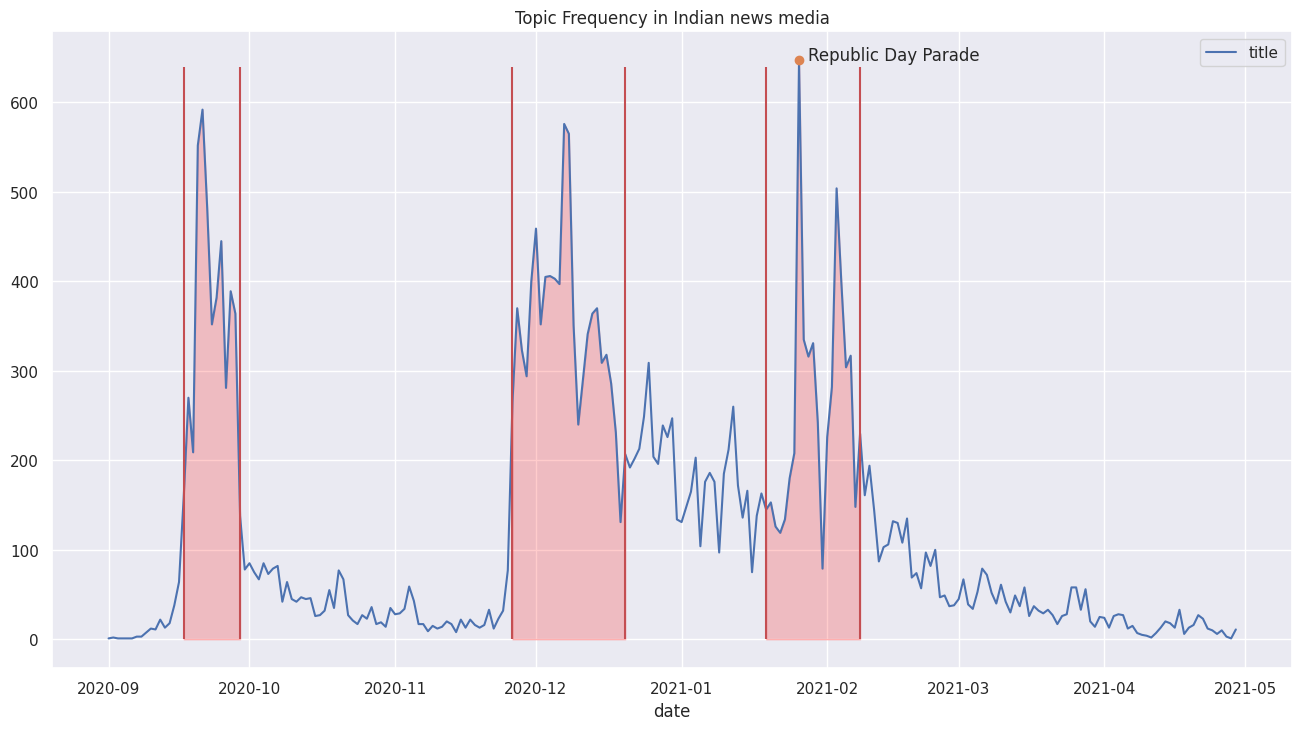

In [27]:
#plotting the graph
sns.set(rc={'figure.figsize':(16,8.27)})
fig, ax = plt.subplots()
sns.lineplot(data = perDate)


#Filling the area of high activity
#Group 1
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[25]) and x >= perDate.index[13]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)
#Group 2
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[107]) and x >= perDate.index[83]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)
#Group 3
ax.fill_between( perDate.index, perDate.title.values, where=([x <= (perDate.index[157]) and x >= perDate.index[137]  
                                                              for x in perDate.index]), color = 'red', alpha = 0.2)


#highlighting the bounds for the each group
#Group 1
ax.vlines(perDate.index[13], 0, 640, color = 'r')
ax.vlines(perDate.index[25], 0, 640, color = 'r')

#Group 2
ax.vlines(perDate.index[83], 0, 640, color = 'r')
ax.vlines(perDate.index[107], 0, 640, color = 'r')

#Group 3
ax.vlines(perDate.index[137], 0, 640, color = 'r')
ax.vlines(perDate.index[157], 0, 640, color = 'r')


#Annotating the event of highest activity 
ax.plot(perDate.index[144], [647], 'o')
plt.annotate('Republic Day Parade',
            xy=(perDate.index[144], 647),  
            xytext=(perDate.index[146], 647)
            )

#title of the graph
title = plt.title('Topic Frequency in Indian news media')


#plt.savefig('topicFreq.png')

#total rows 238

**Finding out the common words using word cloud** 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


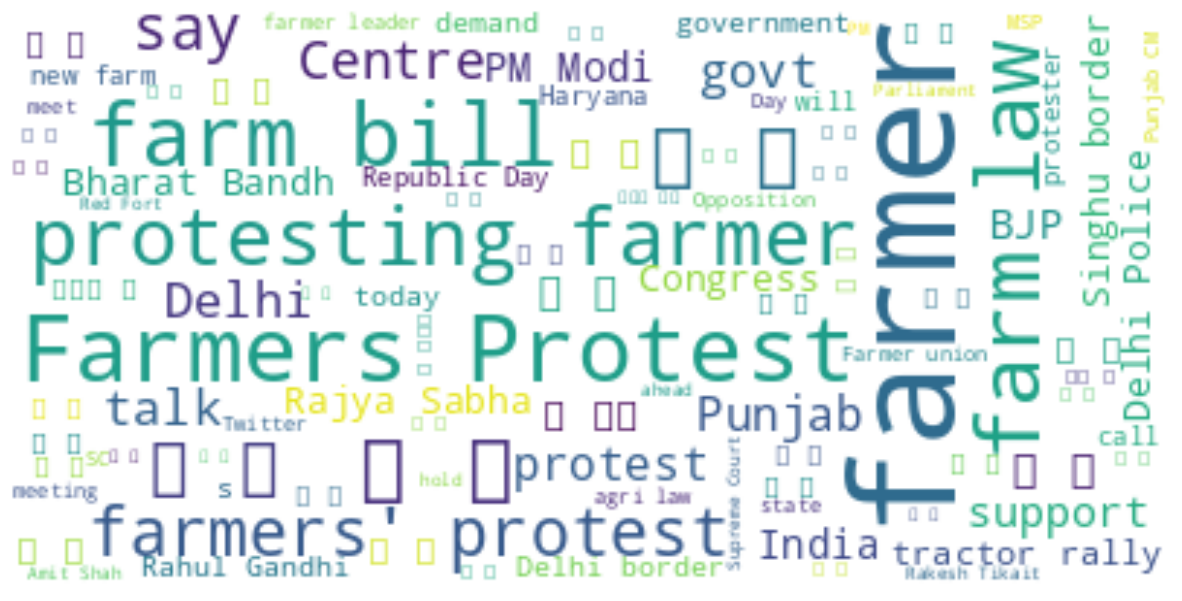

In [28]:
text = " ".join(title for title in all_articles.title)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

**Comment:** Because the topic of data is realted to Farmers' protest, it is no surprise that data we see now shows that too. However there are a lot of 'Hindi' words which did not get highlighted. So word cloud is not the best tool to analyse the words used.  

# Pre processing of the data for different time windows

In [29]:
all_df = all_df.reset_index(drop = True)


# Congress
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('oppn', "congress",  row['title'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Oppn', "congress",  row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('INC', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('UPA', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Opposition', "congress", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('opposition', "congress", row['titleCleaned'])),axis=1)

#Farm Laws
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farm Laws', "FarmLaws", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farm Bills',"FarmBills", row['titleCleaned'])),axis=1)

#FarmersProtest
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farmers Protest',"FarmersProtest", row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Farmers Protests',"FarmersProtest", row['titleCleaned'])),axis=1)

#Rajya Sabha
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('Rajya Sabha', "RajyaSabha" , row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub('RS', "RajyaSabha",  row['titleCleaned'])),axis=1)

#Prime Minister
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Modi", 'pmModi', row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("PM", 'pmModi', row['titleCleaned'])),axis=1)

#FarmersUnion
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Farmer Unions", 'FarmerUnion', row['titleCleaned'])),axis=1)
all_df['titleCleaned'] = all_df.apply(lambda row: (re.sub("Farmer unions", 'FarmerUnion', row['titleCleaned'])),axis=1)




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
groupOne =  all_df[(all_df['date'] >= '2020-09-17') & (all_df['date'] <= '2020-09-29')]
groupTwo = all_df[(all_df['date'] >= '2020-11-26') & (all_df['date'] <= '2020-12-20')]
groupThree = all_df[(all_df['date'] >= '2021-01-19') & (all_df['date'] <= '2021-02-08')]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# TF-IDF correlation matrix for each group

In [31]:
def compile_corpus(articleGroup, topSources):
    compile_dict = {'sources': [], 'corpus' : []}
    for i in range(len(topSources)):
        compile_dict['sources'].append(topSources[i])
        compile_dict['corpus'].append(articleGroup[articleGroup.media_name == topSources[i]]['titleCleaned'].tolist())
    
    return pd.DataFrame(compile_dict)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
def correlationmat(articleGroup, topSources):
    #compiling the text corpus based on news source
    newCorpus = compile_corpus(articleGroup, topSources)
    newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.corpus))]
    # print(newCorpus['allText'])
    #removing stop words
    stops =  list(set([i.lower() for i in stopwords.words('english')]))
    # print(stops)
    #using TF-IDF vectoriser on all the text
    vectorizer = TfidfVectorizer(stop_words= stops)
    transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
    transformed_text_array = transformed_texts.toarray()
    
    #making a correlation matrix
    correlation_matrix = ((transformed_texts * transformed_texts.T).A)
    labels = newCorpus.sources
    sns.heatmap(correlation_matrix, xticklabels= labels, yticklabels= labels)
    plt.title("Text Similarity")
    #plt.savefig('groupThree.png')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/li

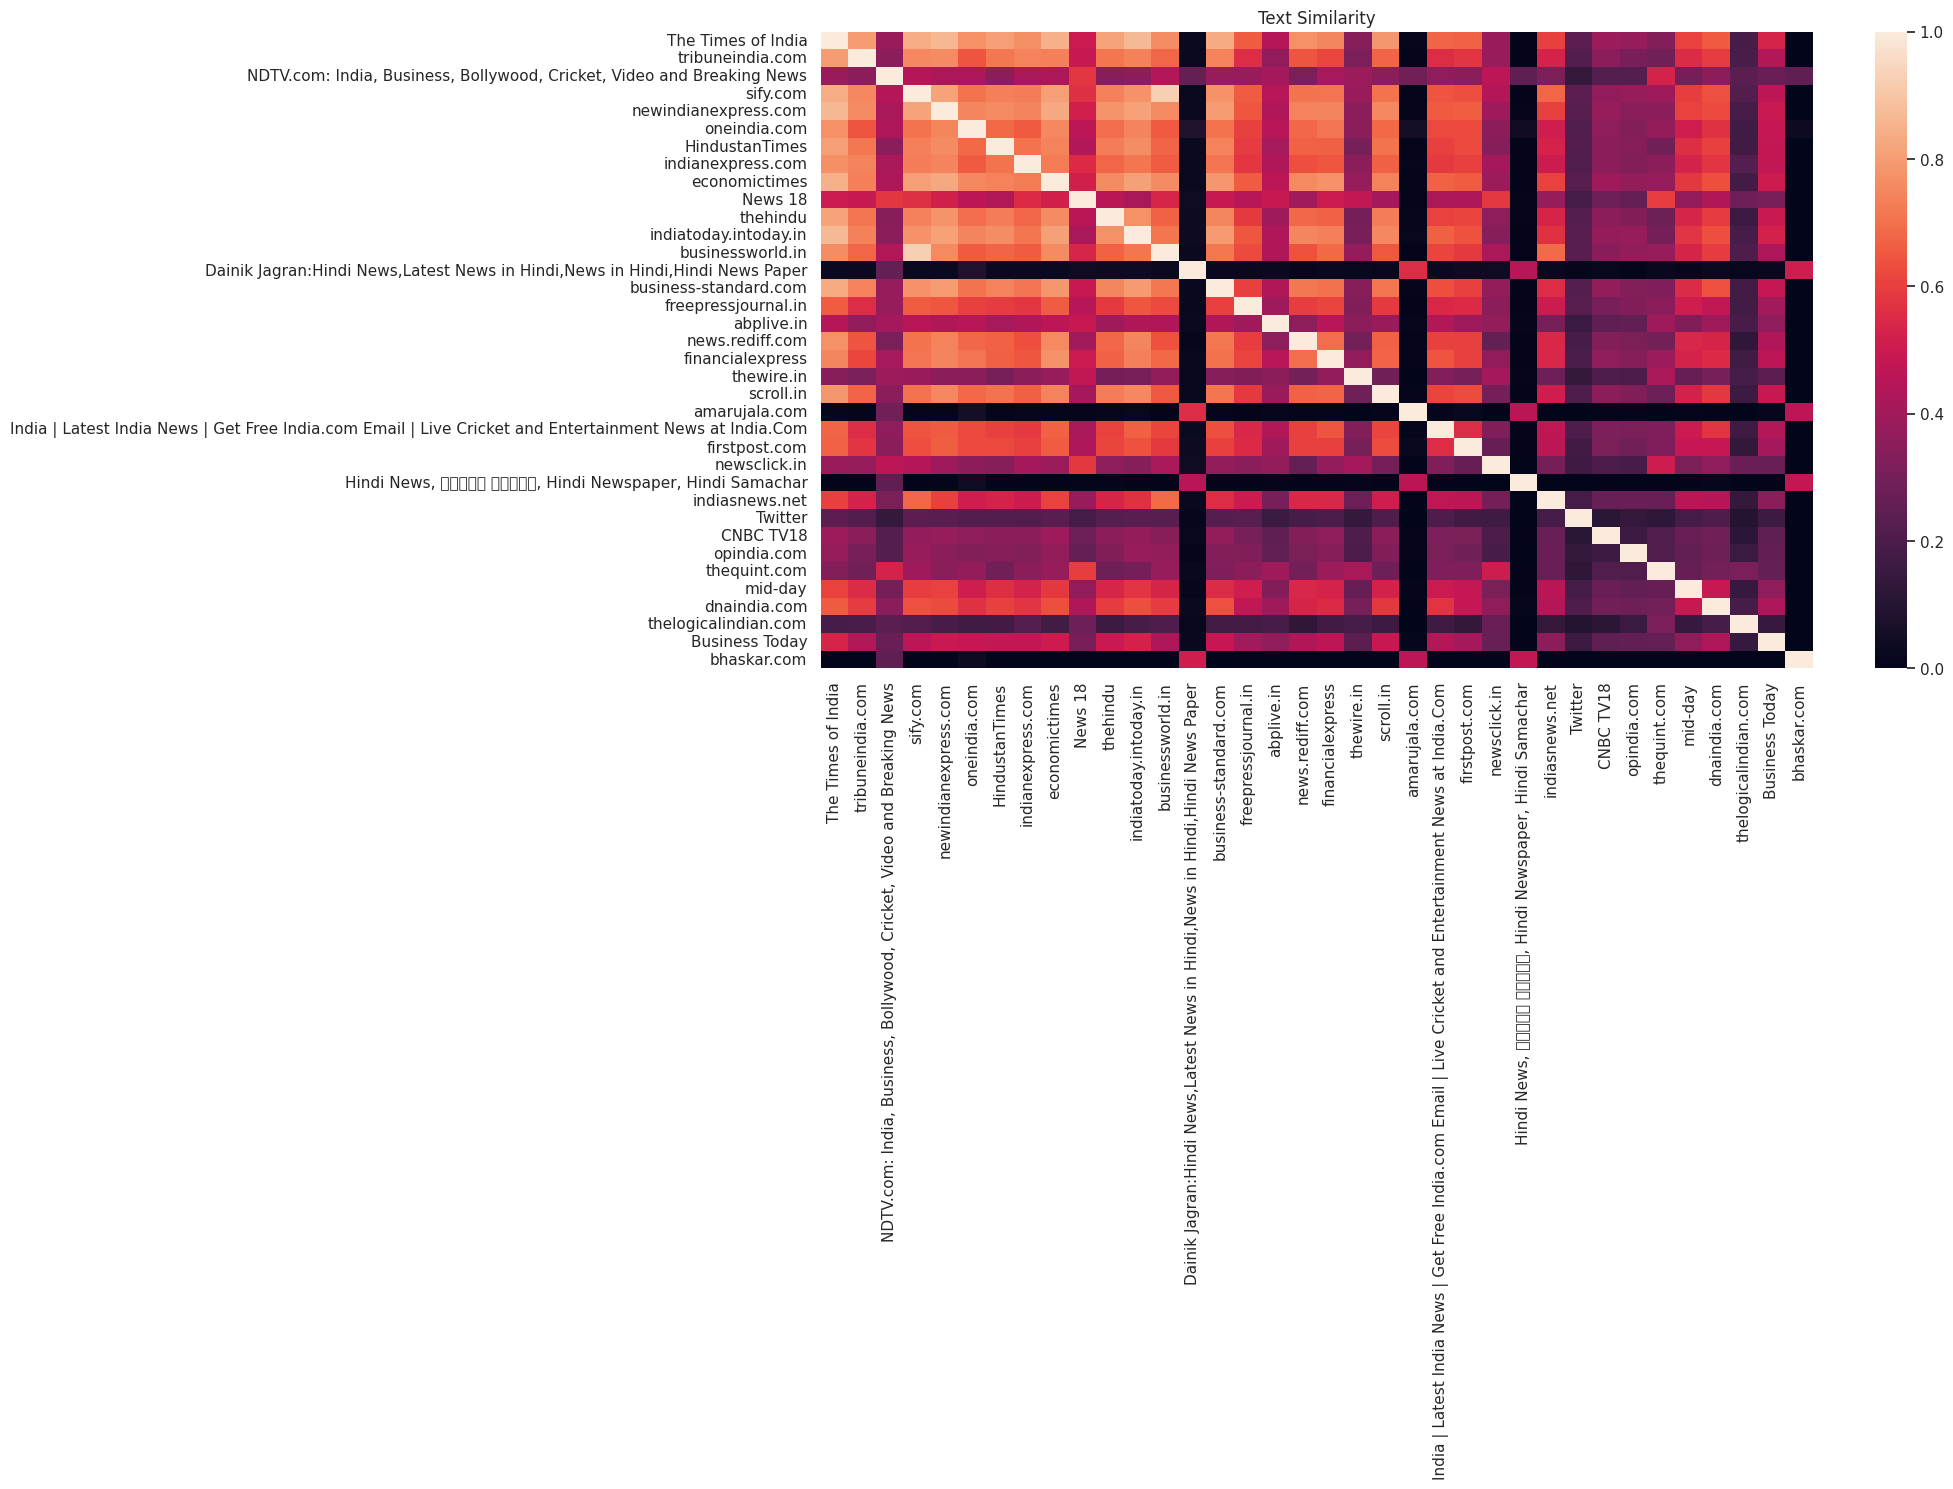

In [33]:
correlationmat(groupOne, topSources)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/li

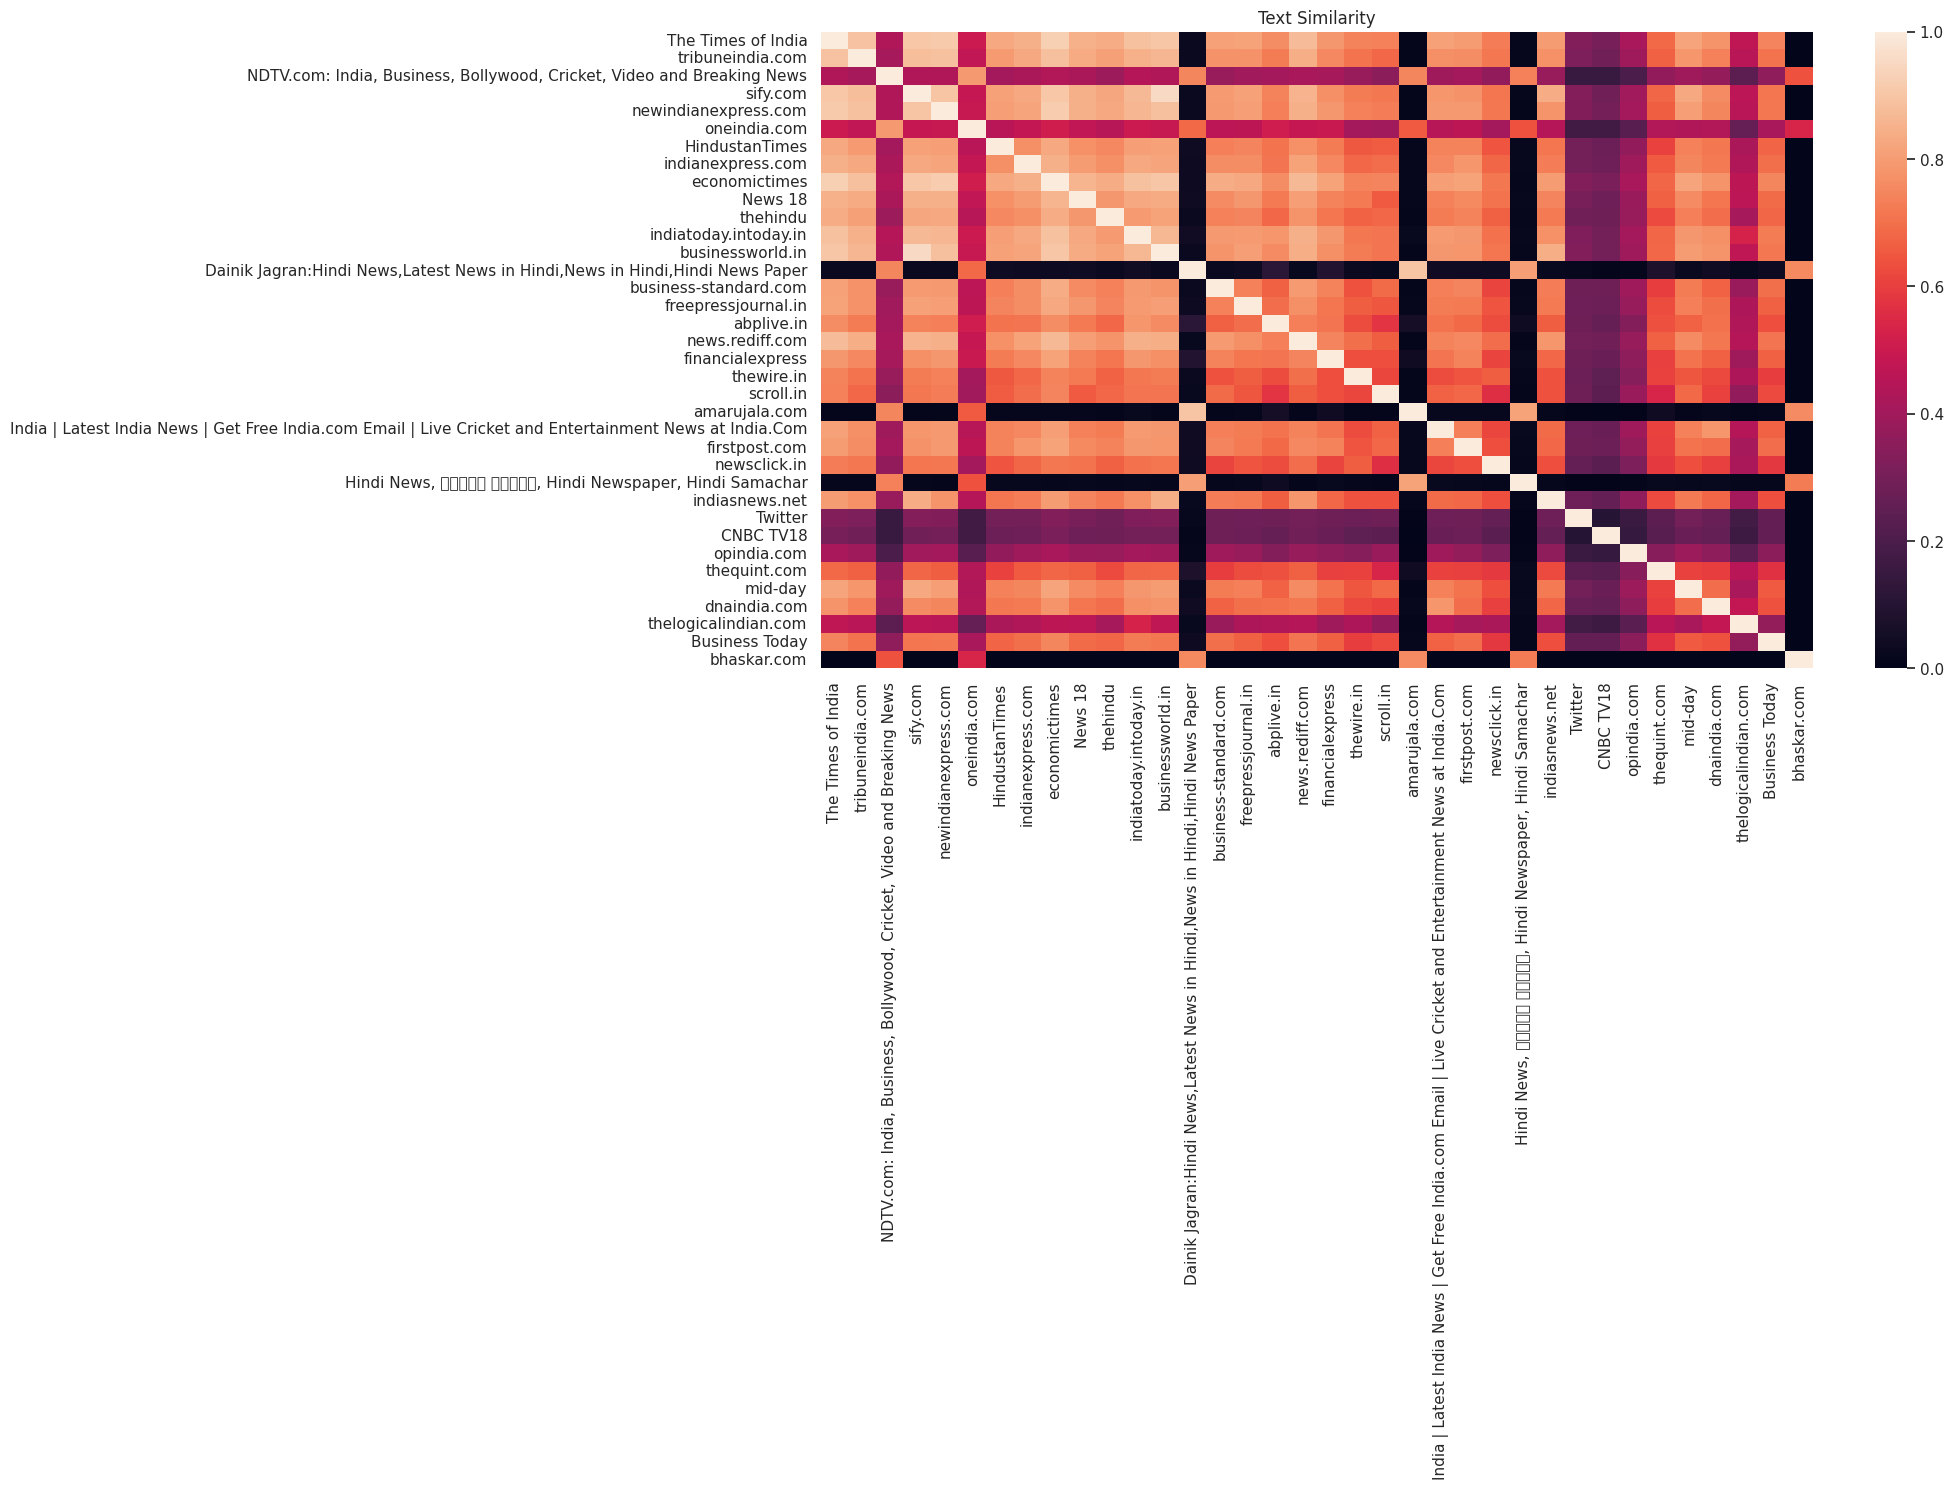

In [34]:
correlationmat(groupTwo, topSources)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/li

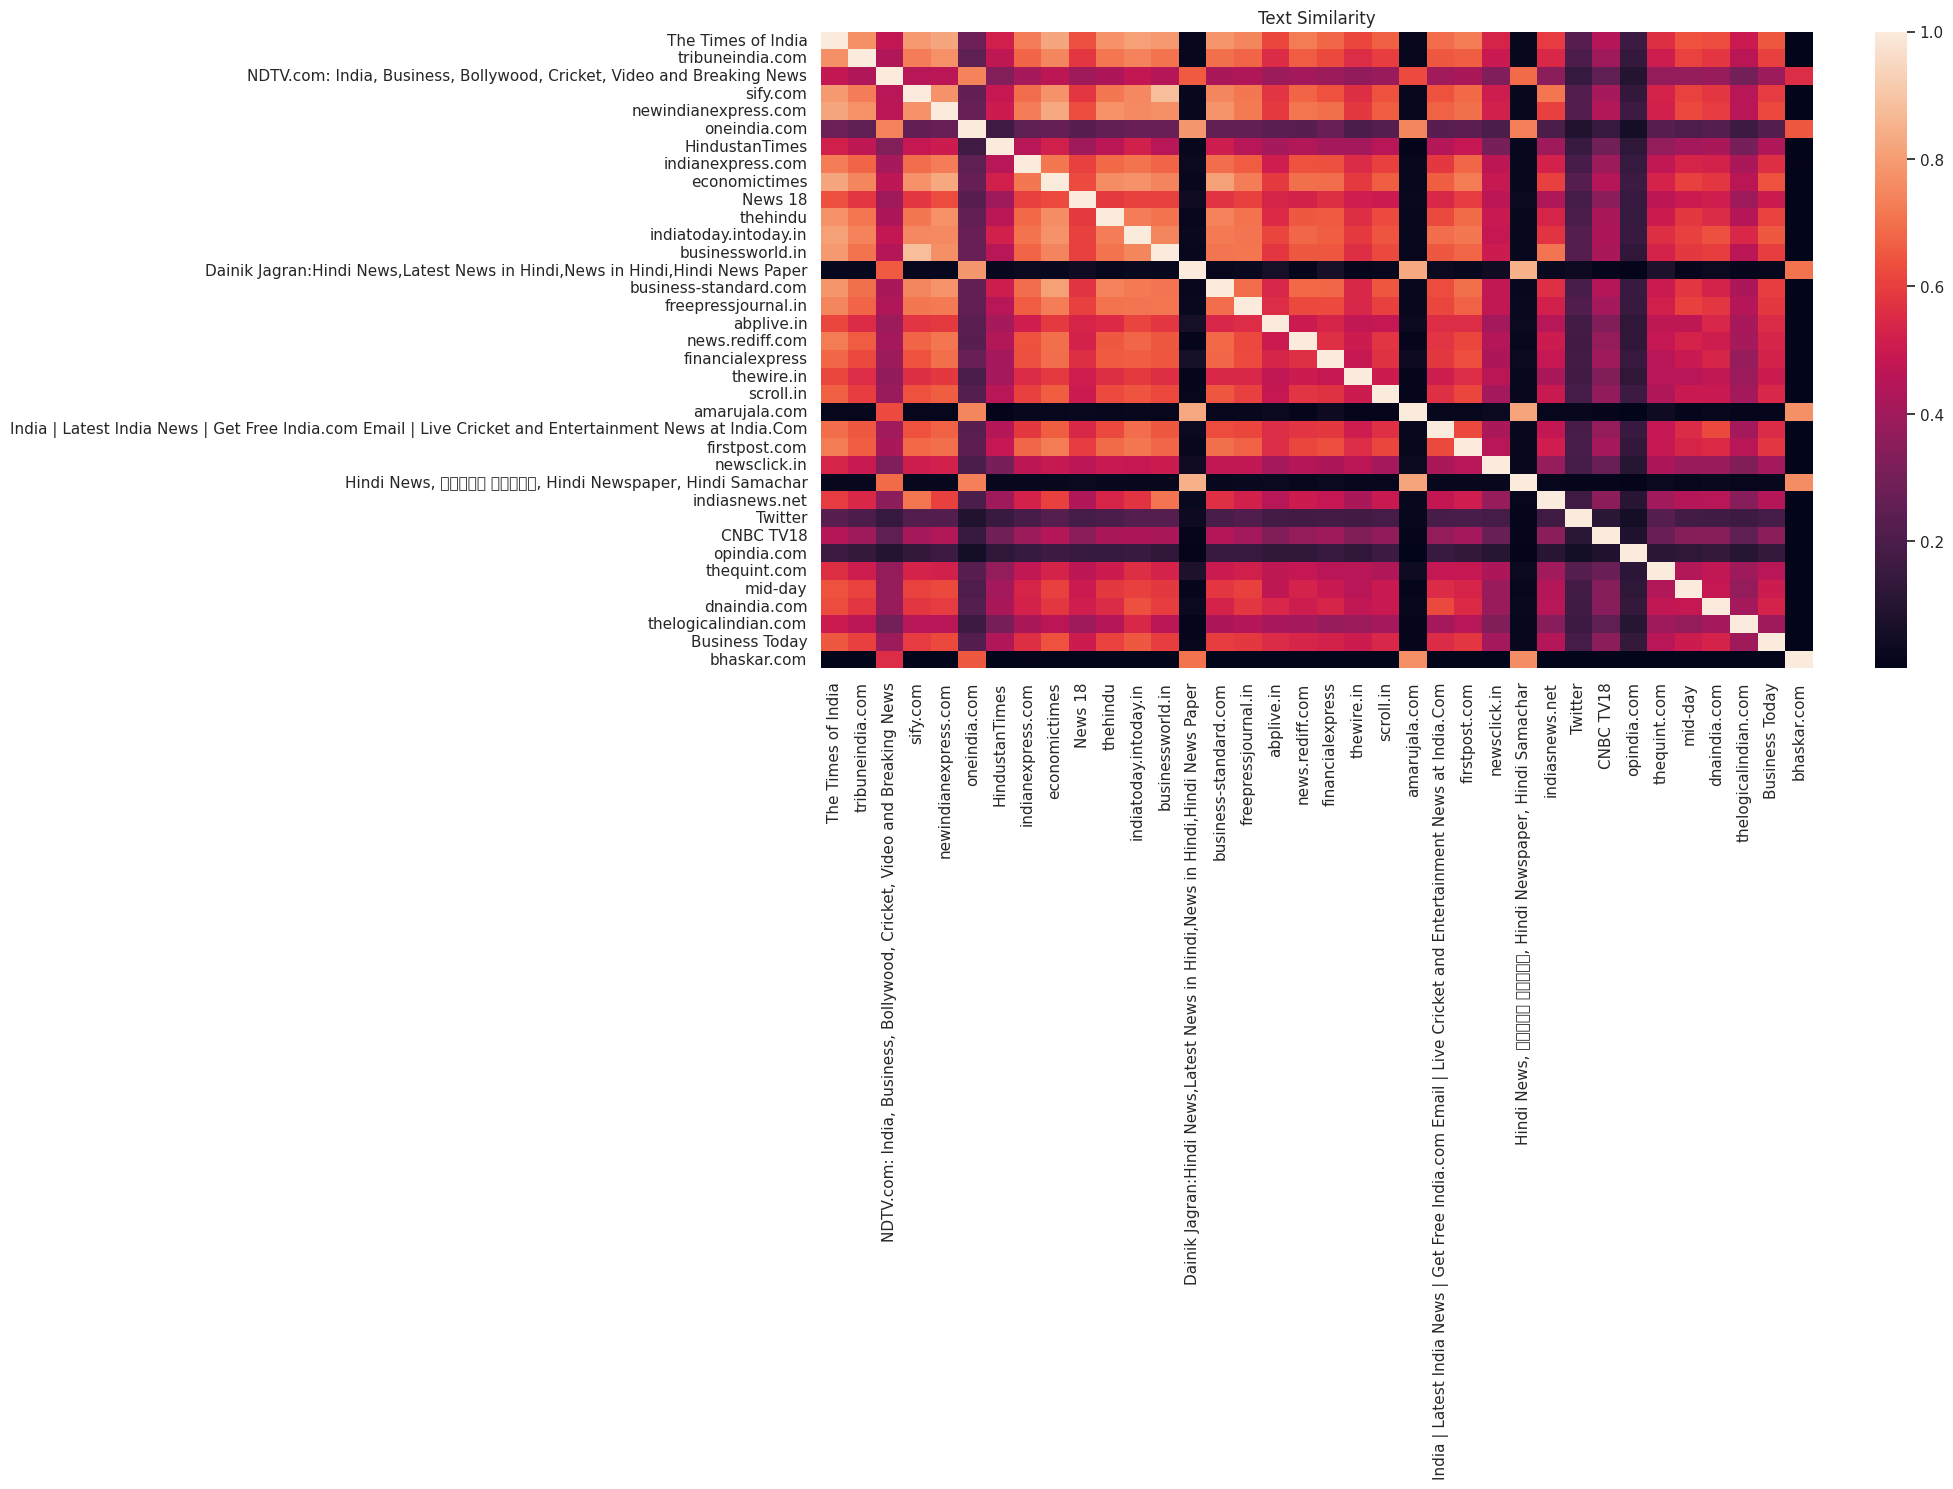

In [35]:
correlationmat(groupThree, topSources)

**Observation:** The hindi newspapers are more similar to each other than english, the context seems to be lost in translation. For a more just comparision the news needs to be translated in english and then compared.

# TF-IDF top ranked words for each group

In [37]:
#resetting the index to compile the groups
groupOne = groupOne.reset_index(drop=True)
groupTwo = groupTwo.reset_index(drop=True)
groupThree = groupThree.reset_index(drop=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
#Compiling the text from all the groups 
newDict = {'sources' : ['groupOne', 'groupTwo', 'groupThree'],
           'Text' : [groupOne['titleCleaned'].to_list(),
                     groupTwo['titleCleaned'].to_list(),
                     groupThree['titleCleaned'].to_list()]}


newCorpus = pd.DataFrame(newDict)
newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.Text))]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
#removing stop words
stops = stop_words = list(set([i.lower() for i in stopwords.words('english')]))

#TF_IDF vectorisation
vectorizer = TfidfVectorizer(stop_words= stops)

transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
transformed_text_array = transformed_texts.toarray()

#########################################################################

#Ranking the high scored TF-IDF words
tf_idf_dataframes = []

#processing each of the group
for counter, txt in enumerate(transformed_text_array):
    
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), txt))
    #Sorting words by TF-IDF scores 
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])

#Making a Data frame from rankings
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = newCorpus.sources
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
#Top 15 wrods for each group
tf_idf_doc_comparison.iloc[:15,:36]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sources,groupOne,groupTwo,groupThree
Tf-IDF Ranking,,,
0,bills,farmers,farmers
1,farm,protest,protest
2,farmers,delhi,delhi
3,congress,protesting,police
4,rajyasabha,farm,tractor
5,farmbills,laws,day
6,protest,border,farm
7,pmmodi,centre,violence
8,punjab,pmmodi,rally


# Embedding-Transformer using SBert and more

In [41]:
#dimensionality reduction and clustering

def encodeNCluster(embeddings, n_components, newsData, dim = 2, n_neighbours = 15):
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbours, n_components= n_components,metric='cosine').fit_transform(embeddings)
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    umap_data = umap.UMAP(n_neighbors=n_neighbours, n_components=dim, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    
    if dim == 3: 
        result = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
    else: 
        result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result.index = newsData.index
    result['labels'] = cluster.labels_
    result['title'] = newsData['title']
    result['newspaper'] = newsData['media_name']
    result['Days']= newsData['Day']
    result['mediaCode'] = newsData['mediaCode'] 
    return result, cluster

# Visualize clusters in 2D with variability slider
def plot2d(result, perDay = False, cmapby = 'labels'):
    fig, ax = plt.subplots(figsize=(10, 8))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]

    topvis = plt.scatter(clustered.x.values, clustered.y.values, c=clustered[cmapby].values , s=0.05, 
                         cmap= 'hsv_r') 
    plt.colorbar()


    plt.subplots_adjust(bottom=0.25)
    saxis =  plt.axes([0.25, 0.1, 0.65, 0.03])
    time_slider = Slider(ax = saxis, label = "date", valmin = result.Days.min(), 
                        valmax = result.Days.max(), 
                        valinit= result.Days.min(), valstep = 1)

    def update(val):
        if perDay:
            x = clustered[clustered.Days == time_slider.val].x.values
            y = clustered[clustered.Days == time_slider.val].y.values
        else: 
            x = clustered[clustered.Days < time_slider.val].x.values
            y = clustered[clustered.Days < time_slider.val].y.values            

        topvis.set_offsets(np.vstack ((x, y)).T)
        draw()

    time_slider.on_changed(update)

    plt.show()
    return fig, ax, time_slider

# Visualize clusters in 3D with variability slider    
def plot3d(result, perDay = False ):    
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(projection='3d')
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]

    top3dvis = ax.scatter(clustered.x.values, clustered.y.values, clustered.z.values, 
                           c=clustered.labels , s=0.05, cmap= 'tab20c') #'hsv_r')


    plt.subplots_adjust(bottom=0.25)
    saxis =  plt.axes([0.25, 0.1, 0.65, 0.03])
    timer_slider = Slider(ax = saxis, label = "Day", valmin = result.Days.min(), 
                        valmax = result.Days.max(), 
                        valinit= result.Days.min(), valstep = 1)

    def update(val):
        if perDay:    
            x = clustered[clustered.Days == timer_slider.val].x.values
            y = clustered[clustered.Days == timer_slider.val].y.values
            z = clustered[clustered.Days == timer_slider.val].z.values
            col = clustered[clustered.Days == timer_slider.val].labels.values
        else: 
            x = clustered[clustered.Days < timer_slider.val].x.values
            y = clustered[clustered.Days < timer_slider.val].y.values
            z = clustered[clustered.Days < timer_slider.val].z.values
            col = clustered[clustered.Days < timer_slider.val].labels.values
        ax.clear()
        ax.scatter(x, y,z , c=col , s=0.05, cmap='hsv_r')

        fig.canvas.draw_idle()

    timer_slider.on_changed(update)

    plt.show()
    return fig, ax, timer_slider

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Loading mbert model
model_mbert = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

#mBert result for Group 1
embeddings_mbert_G1 = model_mbert.encode(groupOne['titleCleaned'].tolist(), show_progress_bar=True)

#mBert result for Group 2
embeddings_mbert_G2 = model_mbert.encode(groupTwo['titleCleaned'].tolist(), show_progress_bar=True)

#mBert result for Group 3
embeddings_mbert_G3 = model_mbert.encode(groupThree['titleCleaned'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
#result for group 1
import umap.umap_ as umap
import hdbscan
result_G1, cluster_G1 = encodeNCluster(embeddings_mbert_G1, 5, groupOne,  n_neighbours = 15)
plot2d(result_G1)

In [ ]:
#result for group 2
result_G2, cluster_G2 = encodeNCluster(embeddings_mbert_G2, 5, groupTwo,  n_neighbours = 15)
plot2d(result_G2)

In [ ]:
#result for group 3
result_G3, cluster_G3 = encodeNCluster(embeddings_mbert_G3, 5, groupThree,  n_neighbours = 15)
plot2d(result_G3)

In [ ]:

#Example result
result_G1[result_G1.labels == 2].title.values

# Creating network of the newspapers covering similar frames

In [ ]:
def NormComparisionDf(result):
    
    #extract clusters and newspapers from the results
    nxresult = result[result.labels > -1].sort_values(by = 'labels')
    nxresult = nxresult.loc[:, ['newspaper', 'labels']]
    
    #defining the list of labels and sources for the loop 
    labelList = sorted(result.labels.unique())[1:]
    allSources = result[result.labels != -1].newspaper.unique()
    
    #instatiating the group proportion dictionary 
    groupDict = {}

    for i in range(len(allSources)):
        #total coverage by the newspaper during the certain period
        allCoverage = nxresult.newspaper.value_counts()[allSources[i]]
        
        #defining the list of variables 
        groupDict[allSources[i]] = []
        
        for j in labelList:
            #if the newspaper is in the frame cluster
            if allSources[i] in nxresult[nxresult.labels == j].newspaper.values:

                #coverage by the newspaper in the particular group
                groupCoverage = nxresult[nxresult.labels == j].newspaper.value_counts()[allSources[i]]

                #proportion of coverage by newspaper in the j label group
                coverageProp = groupCoverage/allCoverage
                
                #adding the proportion of the news coverage in j label from i newspaper
                groupDict[allSources[i]].append(coverageProp)
            
            else:
                
                #if not in the cluster of label j then append zero in the list
                groupDict[allSources[i]].append(0)


    return pd.DataFrame(groupDict, index = labelList)      
        

In [ ]:
#results from 
NormComparisionDf(result_G1).T

In [ ]:
def PairwiseWeights(result, weightColName ):
    
    #weight will be calculated based on results from columns
    weights = cosine_similarity(NormComparisionDf(result).T)
    edgesDict = {'Source A':[], 'Source B': [], weightColName:[]}
    
    #Collection sources from results
    allSources = result[result.labels != -1].newspaper.unique()

    for i in  range(len(allSources)):
        for j in range(i+1 , len(allSources)):

            #tuple of source pair
            edgesDict['Source A'].append(allSources[i])
            edgesDict['Source B'].append(allSources[j])

            #adding normalised weight
            edgesDict[weightColName].append(weights[i][j])

    return pd.DataFrame(edgesDict)

In [ ]:
pairwise_G1 = PairwiseWeights(result_G1, 'weight_G1')
pairwise_G2 = PairwiseWeights(result_G2, 'weight_G2')
pairwise_G3 = PairwiseWeights(result_G3, 'weight_G3')

In [ ]:

#merging all the pairwise weights
compDf = pd.merge(pd.merge(pairwise_G1,pairwise_G2 , on = ['Source A', 'Source B'] ), pairwise_G3, on =['Source A', 'Source B']).fillna(0)
compDf

In [ ]:
compDf.sort_values(by = 'weight_G1', ascending = False)

In [ ]:
#calculating sum of deltas
compDf['sum of deltas'] = abs(compDf['weight_G1'] - compDf['weight_G2']) + abs(compDf['weight_G2'] - compDf['weight_G3']) + abs(compDf['weight_G1'] - compDf['weight_G3'])
compDf

In [ ]:
#reciprocal of sum of deltas
compDf = compDf.sort_values(by = 'sum of deltas')

compDf['weight'] = 1/compDf['sum of deltas']
compDf

In [ ]:
#Average weights
compDf['avg weight'] = (compDf['weight_G1'] + compDf['weight_G2'] + compDf['weight_G3']   ) /3

compDf.sort_values(by = 'avg weight', ascending = False).head(50)

In [ ]:
#Weight distribution
plt.figure(dpi= 150)
plt.hist(compDf['weight_G1'], bins = 100, color= 'black', alpha = .5, label = 'group 1')
plt.hist(compDf['weight_G2'], bins = 100, color= 'blue', alpha = .5, label = 'group 2')
plt.hist(compDf['weight_G3'], bins = 100, color= 'orange', alpha = .5, label= 'group 3')
plt.title('Weight Distribution Comparision')
plt.show()

# Creating graphs and building communities from the weights attained.

In [ ]:

#Creating networks from the newspapers and weights

G1 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G1'
                            )

G2 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G2'
                            )

G3 = nx.from_pandas_edgelist (compDf,
                            source= 'Source A',
                            target= 'Source B',
                            edge_attr= 'weight_G3'
                            )

In [ ]:
#Function to draw adjcency matrix
def draw_grp_adj(Gx, measures, weightAtrr):
    plt.figure(dpi = 150)
    
    #using the measures, grouping the nodes with their communities
    ordered = list(dict(sorted(measures.items(), key=lambda item: item[-1])).keys())
    print("ord",ordered)
    #finding the partitions for the patches
    measurecount = dict(Counter(list(dict(sorted(measures.items(), key=lambda item: item[-1])).values())))
    partitions = list(measurecount.values())
    print("par",partitions)
    
    plt.imshow(nx.to_numpy_array(int(Gx), nodelist = ordered, weight = weightAtrr))
    cbar = plt.colorbar()
    #cbar.set_ticks([0,1])
    cbar.set_label('Weight', rotation=270)
    current_idx = 0
    ax = plt.gca()
    
    #adding squares using matplotlib patches for each group 
    for partition in partitions:
        ax.add_patch(patch.Rectangle((current_idx, current_idx),
                                     partition, # Width
                                     partition, # Height
                                     facecolor="none",
                                     edgecolor='red',
                                     linewidth="2"))
        current_idx += partition
    
    #Adding colorbar for the adjacent matrix
    #cbar.ax.set_yticklabels(['Zero', 'One'])
    cbar.set_label('weights', rotation = 270)
    
    #adding labels to the adjacency matrix graph
    plt.xlabel('node idx')
    plt.ylabel('node idx')
    plt.title('Community adjacency matrix')
    plt.show()
    
## For this question we will be using Louvain best fit method to spot the communities

def draw_clu(G, pos, measures, measure_name):
  
    # Create an array to contain the clusters which have been found
    clusters=np.array(list(set(measures.values())))
    print('clus',clusters)
    # Create a figure to draw the plots and charts
    plt.figure(dpi = 150)

    # Create the plot of the network to be placed in the figure
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()),
                                   linewidths= 0)


    # Add labels to the plot
    labels = nx.draw_networkx_labels(G, pos,font_size = 5)

    # Add edges to the plot
    edges = nx.draw_networkx_edges(G, pos,  width= 0.1)

    # Create the title of the plot
    plt.title(measure_name)

    # Add a colour bar to act as a legend
    cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities')
    cb.ax.tick_params(length=0)
    
    # Adds the community labels to the colour bar
    cb.set_ticklabels(list(set(measures.values())))


    nodes.set_clim(-0.5, len(clusters)-0.5)

    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()

In [ ]:
res = .9
import community 
import networkx as nx

pos1 = nx.spring_layout(G1, seed = 84)
louvain1 = community.best_partition(G1, random_state= 333,resolution= res,weight='weight_G1')

pos2 = nx.spring_layout(G2, seed = 84)
louvain2 = community.community_louvain.best_partition(G2, random_state= 333,resolution= res, weight='weight_G2')

pos3 = nx.spring_layout(G3, seed = 84)
louvain3 = community.community_louvain.best_partition(G3, random_state= 333,resolution= res, weight='weight_G3')



In [ ]:
#G1.edges(data = True)
#louvain1


In [ ]:
draw_clu(G1, pos1, louvain1 ,'Louvain Group 1' )
draw_grp_adj(G1, louvain1, weightAtrr = 'weight_G1' )

draw_clu(G2, pos2, louvain2 ,'Louvain Group 2' )
draw_grp_adj(G2, louvain2, weightAtrr = 'weight_G2')

draw_clu(G1, pos3, louvain3 ,'Louvain Group 3' )
draw_grp_adj(G3, louvain3, weightAtrr = 'weight_G3')

In [ ]:
nx.write_gexf(G1, 'graph_G1.gexf')
nx.write_gexf(G2, 'graph_G2.gexf')
nx.write_gexf(G3, 'graph_G3.gexf')

In [ ]:
#Collect intersecting couples

def getLouvainList(louvain):
    sourceList = []
    uniqueClasses = list(set(louvain1.values()))
    for i in range(len(uniqueClasses)):
        sourceList.append([k for k,v in louvain1.items() if v == i])
    return sourceList

def mostRepeated(louvain1, louvain2, louvain3):
    LL1 = getLouvainList(louvain1)
    LL2 = getLouvainList(louvain2)
    LL3 = getLouvainList(louvain3)
    repeatList = []
    for i in range(len(LL1)):
        for j in range(len(LL2)):
            for k in range(len(LL3)):
                s = set(LL1[i]) & set(LL2[j]) & set(LL3[k])
                if bool(s) == True:
                    repeatList.append(list(s))
    return repeatList

repeatList = mostRepeated(louvain1, louvain2, louvain3)

In [ ]:
repeatList

# Result: Analysis of the network Clusters

In [ ]:
#Let's take a smaller cluter
repeatList[2]

In [ ]:
#Trying to find the cluster where the contributio of all the newspapers is more
compG1 = NormComparisionDf(result_G1)
compG1.loc[:,repeatList[2]].sort_values(by = repeatList[2], ascending = False).head(10)

In [ ]:
#Group 44 seems to be the most susbtantial group
comp11 = result_G1[result_G1.newspaper.isin(repeatList[2]) & (result_G1.labels == 44)].title.to_list()
comp12 = result_G1[result_G1.newspaper.isin(repeatList[2]) & (result_G1.labels == 48)].title.to_list()
comp1 = comp11 + comp12
comp1

**Comment: Group talks about farmers blocking road and solidarity between farmers and other groups**

In [ ]:
#Same process for Group 2
compG2 = NormComparisionDf(result_G2)

compG2.loc[:,repeatList[2]].sort_values(by = repeatList[2], ascending = False).head(10)

In [ ]:
comp21 = result_G2[result_G2.newspaper.isin(repeatList[2]) & (result_G2.labels.isin([66]))].title.to_list()
comp21

**Comments: Talks about police reaction to the reaction to the protesting farmers**

In [ ]:
comp22 = result_G2[result_G2.newspaper.isin(repeatList[2]) & (result_G2.labels.isin([55]))].title.to_list()
comp22

**Comments: Talks about the aids provided to protesting farmers by various communities**

In [ ]:
comp2 = comp21 + comp22

In [ ]:
#Same process for Group 3
compG3 = NormComparisionDf(result_G3)
compG3.loc[:,repeatList[2]].sort_values(by = repeatList[2], ascending = False).head(10)

In [ ]:
comp3 = result_G3[result_G3.newspaper.isin(repeatList[2]) & (result_G3.labels.isin([18]))].title.to_list()
comp3

**Comments: Talks about road blocks**

In [ ]:
#Compiling the text from all the groups 
newDict = {'sources' : ['groupOne', 'groupTwo', 'groupThree'],
           'Text' : [comp1,
                     comp2,
                     comp3]}


newCorpus = pd.DataFrame(newDict)
newCorpus['allText'] = [' '.join(newCorpus.iloc[i][1]) for i in range(len(newCorpus.Text))]

In [ ]:
#removing stop words
stops = stop_words = list(set([i.lower() for i in stopwords.words('english')]))

#TF_IDF vectorisation
vectorizer = TfidfVectorizer(stop_words= stops)

transformed_texts = vectorizer.fit_transform(newCorpus['allText'])
transformed_text_array = transformed_texts.toarray()

#########################################################################

#Ranking the high scored TF-IDF words
tf_idf_dataframes = []

#processing each of the group
for counter, txt in enumerate(transformed_text_array):
    
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), txt))
    #Sorting words by TF-IDF scores 
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])

#Making a Data frame from rankings
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = newCorpus.sources
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']

In [ ]:
#Top 15 wrods for each group
tf_idf_doc_comparison.iloc[:15,:36]

result nnot a generic tool
Frames are just topics, not fine
Louvain differs.
UMAP + HDBSCAN optimisation, different results. 